In [1]:
import pandas as pd
import numpy as np

In [2]:
pitchfork_df = pd.read_csv('pitchfork1.csv')
pitchfork_df=pitchfork_df.append(pd.read_csv('pitchfork2.csv'))
pitchfork_df=pitchfork_df.append(pd.read_csv('pitchfork3.csv'))
pitchfork_df=pitchfork_df.append(pd.read_csv('pitchfork4.csv'))
pitchfork_df = pitchfork_df.reset_index()
print(pitchfork_df.shape)

(12154, 8)


In [3]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
# Hmmm. Why are some of the scores Nan? I am going to turn them into -1
# for now. I think that we should either get a real score for them, or remove them
# from the dataset. Other thoughts?
pitchfork_df.head()
values = {'score':-1}
pitchfork_df = pitchfork_df.fillna(value=values)
#pitchfork_df['score'].values
misc = {'genre':'Misc'}
pitchfork_df = pitchfork_df.fillna(value=misc)

C:\Users\sanderdv\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


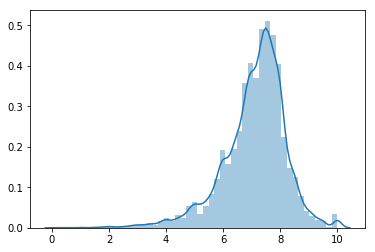

In [5]:
sns.distplot(pitchfork_df['score'].values)

In [6]:
print(np.std(pitchfork_df['score'].values))
print(np.mean(pitchfork_df['score'].values))
print(pitchfork_df['album'][:2])
print(pitchfork_df['album'][:2][0])


1.1022086757701128
7.099473424387033
0                 DJ-Kicks
1    I Trawl the Megahertz
Name: album, dtype: object
DJ-Kicks


In [7]:
pitchfork_df.head()

,index,artist,album,score,genre,review,best,date
0,0,Laurel Halo,DJ-Kicks,7.7,Electronic,"On her first commercial mix album, the produce...",0,March 23 2019
1,1,Prefab Sprout,I Trawl the Megahertz,8.5,Electronic,Best new reissue This lost Prefab Sprout album...,1,March 23 2019
2,2,USA/Mexico,Matamoros,7.3,Rock,"USA/Mexico are sludgy, nasty, and unclassifiab...",0,March 23 2019
3,3,Tamaryn,Dreaming in the Dark,6.5,Rock,"On her new album, Tamaryn aims for sky-high '8...",0,March 23 2019
4,4,Nilüfer Yanya,Miss Universe,8.3,Pop/R&B,Best new music The rapturous debut from the Br...,1,March 22 2019


In [8]:
# I picked 7.0 as an arbitrary cutoff between good and bad.

pitchfork_df['rating'] = np.where(pitchfork_df['score']>7.0,1,0)

In [9]:
pitchfork_df.head()

,index,artist,album,score,genre,review,best,date,rating
0,0,Laurel Halo,DJ-Kicks,7.7,Electronic,"On her first commercial mix album, the produce...",0,March 23 2019,1
1,1,Prefab Sprout,I Trawl the Megahertz,8.5,Electronic,Best new reissue This lost Prefab Sprout album...,1,March 23 2019,1
2,2,USA/Mexico,Matamoros,7.3,Rock,"USA/Mexico are sludgy, nasty, and unclassifiab...",0,March 23 2019,1
3,3,Tamaryn,Dreaming in the Dark,6.5,Rock,"On her new album, Tamaryn aims for sky-high '8...",0,March 23 2019,0
4,4,Nilüfer Yanya,Miss Universe,8.3,Pop/R&B,Best new music The rapturous debut from the Br...,1,March 22 2019,1


In [10]:
pitchfork_df['review'][0][0]

'O'

In [11]:
def cleanReview(stringToClean):
    return prepStringForProcessing(stringToClean)

def prepStringForProcessing(inputString):
    # this code cleans a string. It takes
    # a string and removes the puncuation 
    # from the string. The cleaned string 
    # is returned
    
    # remove puncuation
    outputString = inputString.replace(',','')
    outputString = outputString.replace('.','')
    outputString = outputString.replace(':','')
    outputString = outputString.replace(';','')
    outputString = outputString.replace('@','')
    outputString = outputString.replace('"','')
    outputString = outputString.replace("'","")
    outputString = outputString.replace("'","")
    outputString = outputString.replace('?','')
    outputString = outputString.replace('!','')
    outputString = outputString.replace('#','')
    outputString = outputString.replace('%','')
    outputString = outputString.replace('&','')
    outputString = outputString.replace('$','')
    outputString = outputString.replace('^','')
    outputString = outputString.replace('*','')
    outputString = outputString.replace('(','')
    outputString = outputString.replace(')','')
    outputString = outputString.replace('!','')
    outputString = outputString.replace('-','')
    return outputString.lower();


In [12]:
for i in range(0,len(pitchfork_df)-1):
    pitchfork_df['review'][i] = cleanReview(pitchfork_df['review'][i])

C:\Users\sanderdv\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
pitchfork_df.head()

,index,artist,album,score,genre,review,best,date,rating
0,0,Laurel Halo,DJ-Kicks,7.7,Electronic,on her first commercial mix album the producer...,0,March 23 2019,1
1,1,Prefab Sprout,I Trawl the Megahertz,8.5,Electronic,best new reissue this lost prefab sprout album...,1,March 23 2019,1
2,2,USA/Mexico,Matamoros,7.3,Rock,usa/mexico are sludgy nasty and unclassifiable...,0,March 23 2019,1
3,3,Tamaryn,Dreaming in the Dark,6.5,Rock,on her new album tamaryn aims for skyhigh 80sg...,0,March 23 2019,0
4,4,Nilüfer Yanya,Miss Universe,8.3,Pop/R&B,best new music the rapturous debut from the br...,1,March 22 2019,1


In [14]:
import nltk
from nltk.stem.porter import PorterStemmer

def tokenizeStem(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [15]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer,TfidfTransformer  
from sklearn.model_selection import GridSearchCV  
from sklearn.naive_bayes import MultinomialNB  

from sklearn.pipeline import Pipeline  
from time import time  
from sklearn.svm import LinearSVC

In [18]:


minisize = .99

t0 = time()  
X = pitchfork_df['review']
y = pitchfork_df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=minisize, random_state=42)
X_train_mini, X_test_mini, y_train_mini, y_test_mini = train_test_split(X_test, y_test,test_size=0.25)

pipeline = Pipeline([
    ('vec', CountVectorizer(tokenizer=tokenizeStem, max_df=0.5, max_features=700000, min_df=1, ngram_range=(1,3))),
    ('tfidf', TfidfTransformer()), 
    ('clf', LinearSVC())])
pipeline.fit(X_train_mini, y_train_mini)
print(pipeline)
print(pipeline.score(X_test_mini, y_test_mini))

print("done in {0}s".format(time() - t0))  

Pipeline(memory=None,
     steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=700000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        stri...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
0.7580591558657361
done in 638.5159378051758s


In [19]:

print(pipeline.score(X_test_mini, y_test_mini))

0.7580591558657361


In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanderdv\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [20]:
#order by score from high to low
ranked = pitchfork_df.sort_values(by='score', ascending=False)

In [21]:
#show top 50 scores
ranked.head(50)

,index,artist,album,score,genre,review,best,date,rating
2612,2612,Björk,Homogenic,10.0,Electronic,homogenic embraced all of björk’s most provoca...,0,February 5 2017,1
8843,2749,Talk Talk / Mark Hollis,Laughing Stock / Mark Hollis,10.0,Rock,best new reissue best new reissue 1 / 2 albums...,1,October 21 2011,1
2533,2533,Weezer,Weezer (Blue Album),10.0,Rock,weezer’s 1994 debut filled with geeky humor de...,0,February 26 2017,1
3578,530,Prince,Dirty Mind,10.0,Pop/R&B,prince’s first fully actualized album is an un...,0,April 29 2016,1
8933,2839,Nirvana,Nevermind [20th Anniversary Edition],10.0,Rock,twenty years on the album that changed the cou...,0,September 27 2011,1
11299,2161,The Stone Roses,The Stone Roses,10.0,Rock,best new reissue a badly needed remaster of th...,1,September 11 2009,1
9941,803,Weezer,Pinkerton [Deluxe Edition] / Death to False Metal,10.0,Rock,best new reissue 1 / 2 albums weezers overlook...,1,November 3 2010,1
11302,2164,The Beatles,Abbey Road,10.0,Rock,the perfect ending to a recording career this ...,0,September 10 2009,1
11304,2166,The Beatles,The Beatles,10.0,Rock,indulgent sprawling overflowing with ideas and...,0,September 10 2009,1
1543,1543,Metallica,Master of Puppets,10.0,Metal,best new reissue in 1986 metallica released in...,1,December 2 2017,1


In [22]:
#find all unique genres
genres = pitchfork_df.genre.unique()

In [23]:
genres

array(['Electronic', 'Rock', 'Pop/R&B', 'Rap', 'Jazz', 'Experimental',
       'Metal', 'Folk/Country', 'Misc', 'Global'], dtype=object)

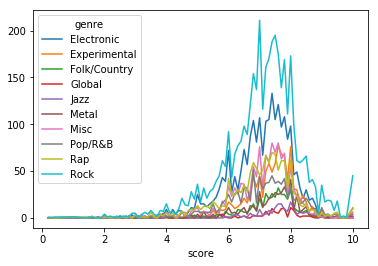

In [24]:
#Create line graph of scores by genre
ranked.groupby(['score','genre']).size().unstack(fill_value=0).plot()

In [25]:
#Create list with the average album score by genre
avg_score = ranked.groupby(['genre'])['score'].agg(lambda x: x.unique().mean())

In [26]:
avg_score

genre
Electronic      5.864384
Experimental    6.721053
Folk/Country    6.766000
Global          7.276667
Jazz            7.553846
Metal           6.570909
Misc            6.082540
Pop/R&B         6.389062
Rap             5.997183
Rock            5.890000
Name: score, dtype: float64

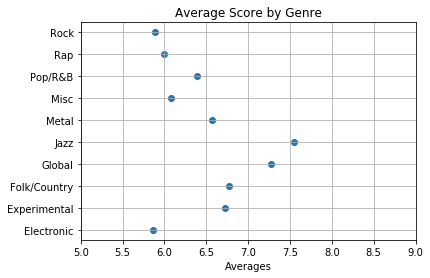

In [78]:
#Create scatter plot of average score by genre
plt.title("Average Score by Genre") #add title

plt.xlim(left=5, right=9) #set table start and end values

plt.xlabel("Averages") #add x-axis label

plt.grid(b=True, which='major', axis='both') #add grid lines

plt.scatter(avg_score[:],avg_score.index)

In [28]:
#Create dataframe of albums with a perfect score of 10
perfect = pd.DataFrame(data=None, index=None, columns=pitchfork_df.columns)
for i in range(len(pitchfork_df)):
    if pitchfork_df['score'][i] == 10.0:
        perfect = perfect.append(pitchfork_df.loc[i])

In [29]:
perfect.shape

(79, 9)

In [30]:
perfect

,index,artist,album,score,genre,review,best,date,rating
176,176,Alice Coltrane,Journey in Satchidananda,10.0,Jazz,each sunday pitchfork takes an indepth look at...,0,February 3 2019,1
239,239,Talk Talk,Spirit of Eden,10.0,Rock,each sunday pitchfork takes an indepth look at...,0,January 13 2019,1
456,456,Talking Heads,Remain in Light,10.0,Rock,each sunday pitchfork takes an indepth look at...,0,October 21 2018,1
490,490,Bikini Kill,The Singles,10.0,Rock,best new reissue newly reissued on vinyl bikin...,1,October 11 2018,1
556,556,De La Soul,3 Feet High and Rising,10.0,Rap,each sunday pitchfork takes an indepth look at...,0,September 23 2018,1
581,581,PJ Harvey,Rid of Me,10.0,Rock,each sunday pitchfork takes an indepth look at...,0,September 16 2018,1
916,916,The Band,The Band,10.0,Rock,each sunday pitchfork takes an indepth look at...,0,June 10 2018,1
942,942,Hole,Live Through This,10.0,Rock,each sunday pitchfork takes an indepth look at...,0,June 3 2018,1
1057,1057,Liz Phair,Girly-Sound to Guyville: The 25th Anniversary ...,10.0,Rock,best new reissue liz phair’s indelible essenti...,1,May 2 2018,1
1070,1070,Captain Beefheart and His Magic Band,Trout Mask Replica,10.0,Experimental,best new reissue captain beefheart’s 1969 mast...,1,April 28 2018,1


In [34]:
#Count the number of perfect scores by artist
perf_counts = perfect['artist'].value_counts()

In [35]:
perf_counts

The Beatles                             7
Prince                                  3
The Velvet Underground                  3
Weezer                                  2
David Bowie                             2
Radiohead                               2
Metallica                               2
Nirvana                                 2
Prince / The Revolution                 2
The Rolling Stones                      2
Talk Talk / Mark Hollis                 1
William Basinski                        1
GZA                                     1
The Smiths                              1
R.E.M.                                  1
Mobb Deep                               1
De La Soul                              1
Hole                                    1
X-Ray Spex                              1
Liz Phair                               1
Talking Heads                           1
J Dilla                                 1
Björk                                   1
Fleetwood Mac                     

In [31]:
perf_artists = perfect.artist.unique()

In [45]:
#Create data frame with artists who have multiple perfect scores
perf_multi = pd.DataFrame(data=None, index=None, columns=['Artist','Albums'])
for i in range(len(perf_counts)):
    if perf_counts.values[i] > 1:
        perf_multi = perf_multi.append({'Artist' : perf_counts.index[i], 'Albums' : perf_counts.values[i]}, ignore_index=True)

In [46]:
perf_multi

,Artist,Albums
0,The Beatles,7
1,Prince,3
2,The Velvet Underground,3
3,Weezer,2
4,David Bowie,2
5,Radiohead,2
6,Metallica,2
7,Nirvana,2
8,Prince / The Revolution,2
9,The Rolling Stones,2


[Text(0, 0, 'The Beatles'),
 Text(0, 0, 'Prince'),
 Text(0, 0, 'The Velvet Underground'),
 Text(0, 0, 'Weezer'),
 Text(0, 0, 'David Bowie'),
 Text(0, 0, 'Radiohead'),
 Text(0, 0, 'Metallica'),
 Text(0, 0, 'Nirvana'),
 Text(0, 0, 'Prince / The Revolution'),
 Text(0, 0, 'The Rolling Stones')]

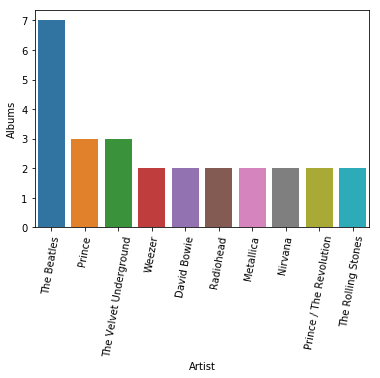

In [77]:
#Create bar graph of artists who have multiple perfect scores and the total perfect score per artist
ax = sns.barplot(x="Artist", y="Albums", data=perf_multi)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)